# Phenotypes

In this notebook, we analyze the data containing information about cell phenotypes.
To perform this analysis, it is necessary to first execute the script `dat_ph_aspect_ratio.py`, which processes the contents of the `dat` folder and generates the following output:

- A folder named `dat_phenotype`, which contains `.dat` files with the mean aspect ratio, the fraction of elongated cells, the fraction of round cells, and the fraction of binary cells at each time step and for each seed.

As mentioned above, there are three types of phenotypes, defined as follows:

- **Elongated cells**: Cells with maximum aspect ratio (specifically equal to 2.7) and maximum velocity.  
- **Round cells**: Passive cells with an aspect ratio equal to 1.  
- **Binary cells**: Cells with an aspect ratio between 1 and the maximum value, and a velocity greater than 0 but lower than the maximum.


## Phenotypes evolution

First of all, let's calculate how the phenotypes change in time arriving to an steady state for a given density.

In [1]:
# import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

We define some relevant parameters that remains constant during the simulations.

In [2]:
nc = 10_000
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each phenotype and the aspect ratio for each step.

In [3]:
def calculate_phenotype_vs_time(num_cells, dens, max_step, step, rng_seed):
    """
    Calculates phenotypes and the aspect ratio as a function of time
    for a given density and list of seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    """

    # Initialize the lists for each phenotype and the aspect ratio
    fraction_elongated = []
    fraction_round = []
    fraction_binary = []
    mean_aspect_ratio = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        fraction_elongated_cells_step = np.array([])
        fraction_round_cells_step = np.array([])
        fraction_binary_cells_step = np.array([])
        mean_aspect_ratio_step = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"{dens_folder}/dat_phenotype/phenotype_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            mean_aspect_ratio_seed = df_tic["mean_aspect_ratio"].mean()
            fraction_elongated_seed = df_tic["fraction_elongated"].mean()
            fraction_round_seed = df_tic["fraction_round"].mean()
            fraction_binary_seed = df_tic["fraction_binary"].mean()
            # Add them to the steps's array
            mean_aspect_ratio_step = np.append(mean_aspect_ratio_step, mean_aspect_ratio_seed)
            fraction_elongated_cells_step = np.append(fraction_elongated_cells_step, fraction_elongated_seed)
            fraction_round_cells_step = np.append(fraction_round_cells_step, fraction_round_seed)
            fraction_binary_cells_step = np.append(fraction_binary_cells_step, fraction_binary_seed)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        mean_aspect_ratio_mean = np.mean(mean_aspect_ratio_step)
        fraction_elongated_mean = np.mean(fraction_elongated_cells_step)
        fraction_round_mean = np.mean(fraction_round_cells_step)
        fraction_binary_mean = np.mean(fraction_binary_cells_step)

        # Add them to the global list
        mean_aspect_ratio.append(mean_aspect_ratio_mean)
        fraction_elongated.append(fraction_elongated_mean)
        fraction_round.append(fraction_round_mean)
        fraction_binary.append(fraction_binary_mean)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "mean_aspect_ratio": mean_aspect_ratio,
        "fraction_elongated": fraction_elongated,
        "fraction_round": fraction_round,
        "fraction_binary": fraction_binary,
    })

    return df

### Particular density

In the case we want to see only one particular density, continue as follows. We get the dataframe with the function and then plot it.

In [4]:
dens_input = input("Enter density (for example 0.90): ")
try:
    density = float(dens_input)
except ValueError:
    print("Error")
    exit()
df = calculate_phenotype_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
#df.to_csv("{density_folder}/ph_vs_time.csv", index=False)

Last step =  50000  for density =  0.5


In [5]:
def plot_order_parameters_evolution(df, dens):
    """
    Plots the temporal evolution of the phenotypes and mean aspect ratio
    for a given cell density.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    dens : float
        Cell density used in the simulation.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # First plot
    axs[0].plot(df["step"], df["fraction_elongated"], label="Fraction of elongated cells", color="red")
    axs[0].plot(df["step"], df["fraction_round"], label="Fraction of round cells", color="blue")
    axs[0].plot(df["step"], df["fraction_binary"], label="Fraction of binary cells", color="green")
    axs[0].set_title("Phenotypes")
    axs[0].set_ylabel("Fraction of cells")
    axs[0].legend()

    # Second plot
    axs[1].plot(df["step"], df["mean_aspect_ratio"], label="Mean aspect ratio", color="orange")
    axs[1].set_title("Mean aspect ratio")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Aspect ratio")
    axs[1].legend()

    fig.suptitle(f"Phenotypes and Mean Aspect Ratio vs Time (density = {dens})")
    plt.tight_layout()

    # Guardar el gráfico
    folder_path = f"graphs/phenotypes/ph_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"ph_evolution_density_{dens:.2f}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

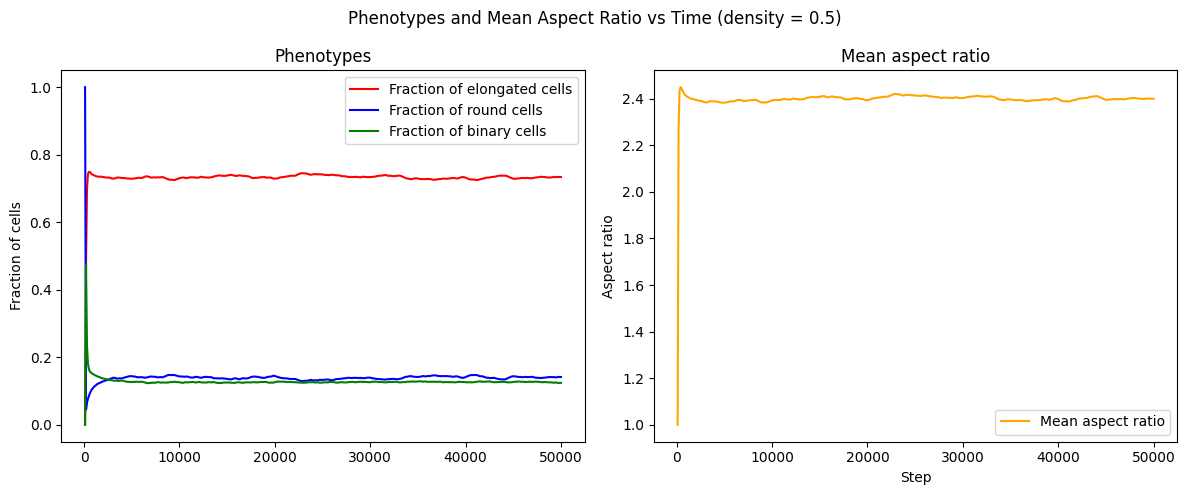

In [6]:
plot_order_parameters_evolution(df, dens=density)

### All densities

In the case we want to see all the densities, we can proceed like this: 

Last step =  50000  for density =  0.5


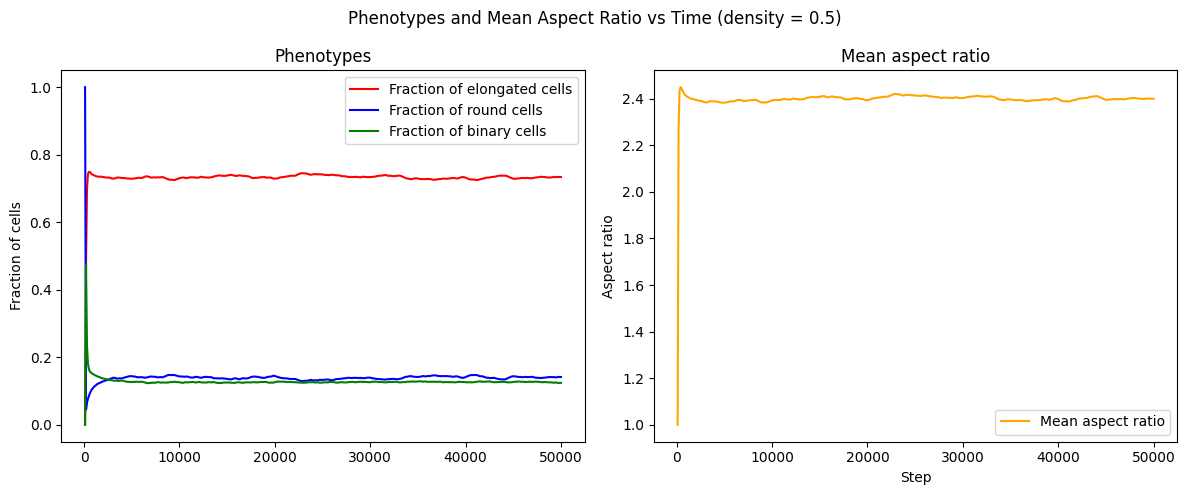

Last step =  50000  for density =  0.6


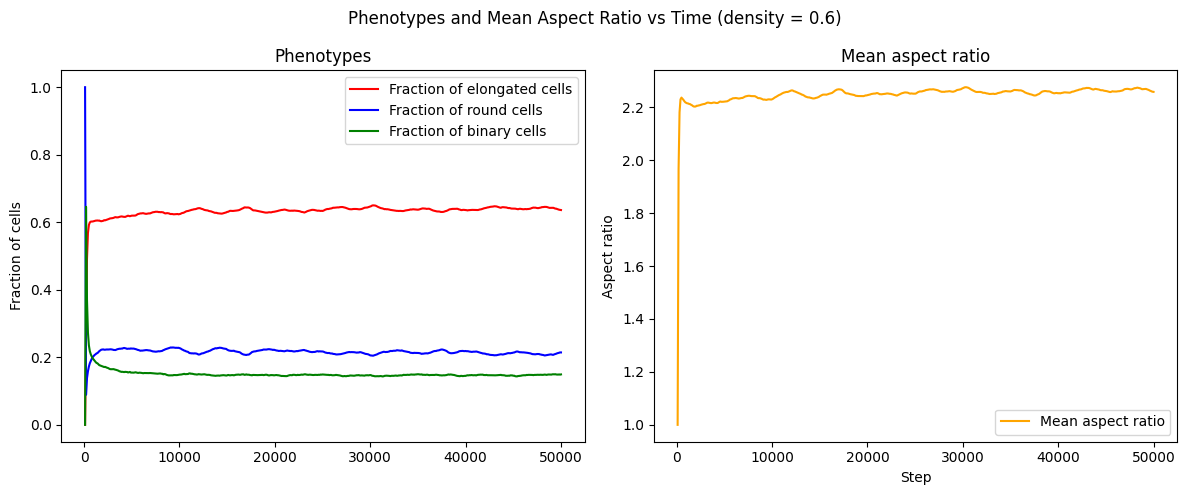

Last step =  50000  for density =  0.7


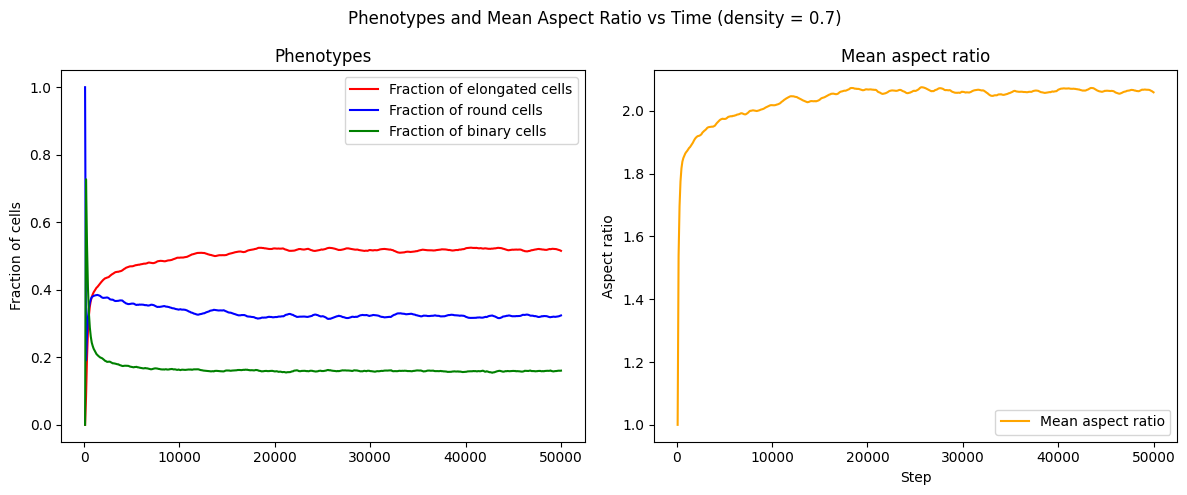

Last step =  50000  for density =  0.8


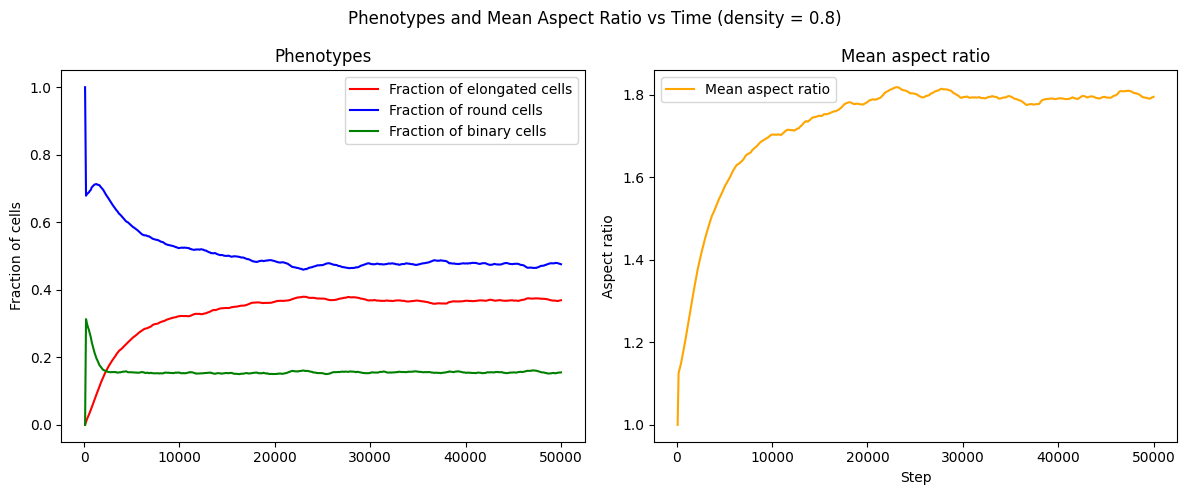

Last step =  48300  for density =  0.85


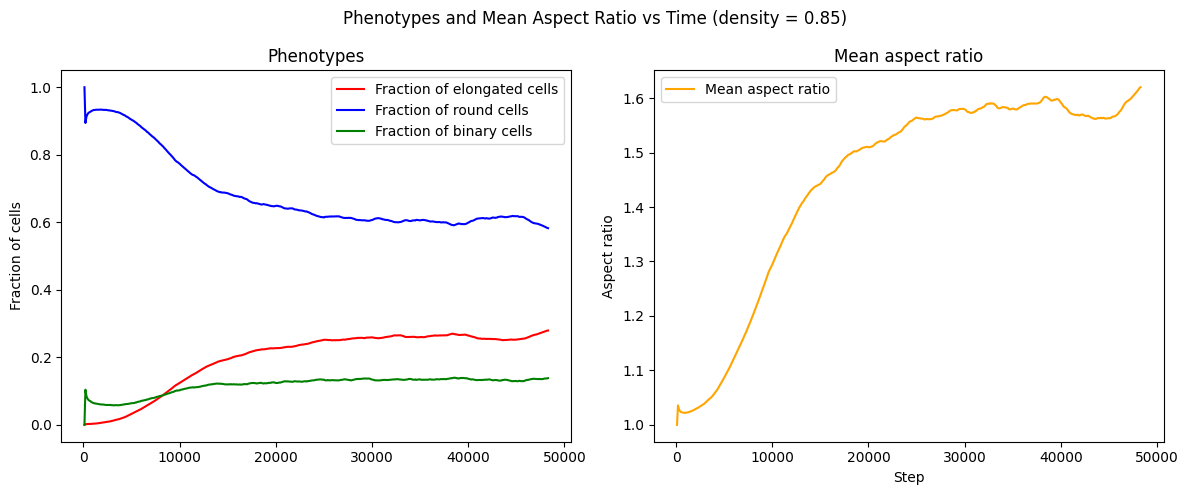

Last step =  10000  for density =  0.9


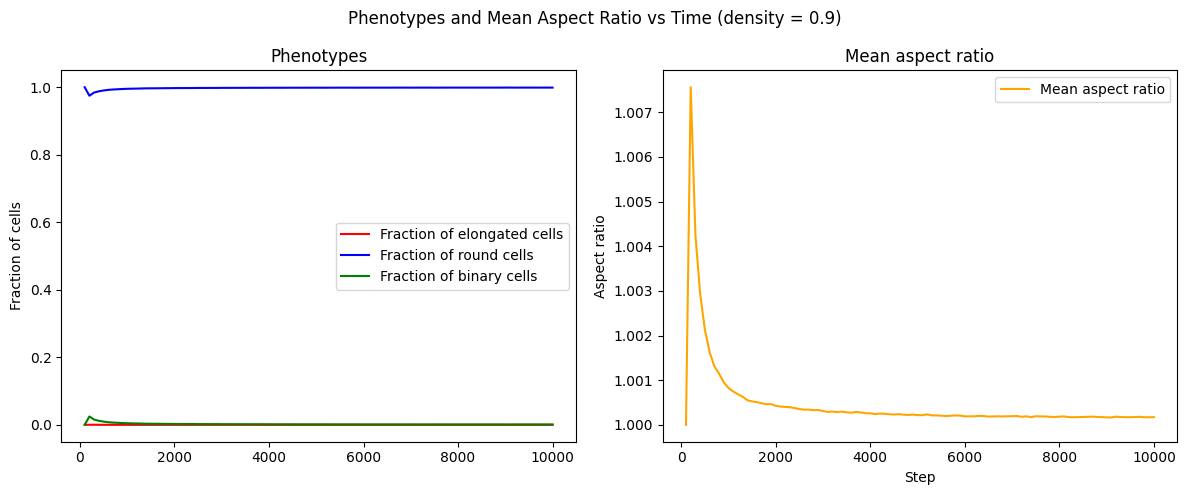

In [7]:
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
# Create a dict to save all the dataframes
dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_phenotype_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/ph_vs_time_density_{density:.2f}.csv", index=False)
    # Add it to the dict
    dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_order_parameters_evolution(df, dens=density)